In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import percentileofscore

import matplotlib.pyplot as plt
import seaborn as sns

from arch import arch_model
from arch.__future__ import reindexing

In [2]:
def get_volatility(df) : 
    frequency_return = df.pct_change().dropna()
    volatility = np.sqrt(252) * frequency_return.std()
    return volatility.dropna()

def get_skew(df) : 
    frequency_return = df.pct_change().dropna()
    skew = df.skew()
    return skew.dropna()

def get_average_return(df): 
    avg_ret = df.pct_change().dropna().mean() * 252
    avg_ret = pd.DataFrame(avg_ret, columns=["Average Return"]) 
    return avg_ret

def get_robust_skew(df) : 
    frequency_return = df.pct_change().dropna()
    frequency_return_mean = frequency_return.mean()
    frequency_return_median = frequency_return.median()
    frequency_return_std = frequency_return.std()
    robust_skew = (frequency_return_mean - frequency_return_median) / frequency_return_std
    return robust_skew

def get_information_ratio(df, bc) : 
    frequency_return = df.pct_change().dropna()
    bc_return = bc.pct_change().dropna()
    excess_returns = frequency_return.subtract(bc_return, axis=0)
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1) 
    information_ratio = mean_excess_return / std_excess_return
    return information_ratio

def get_excess_kurtosis(df) : 
    frequency_return = df.pct_change().dropna()
    excess_kurtosis = df.kurt() - 3
    return excess_kurtosis.dropna()

def get_sharpe_ratio(df) : 
    frequency_return = df.pct_change().dropna()
    sharpe_ratio = np.sqrt(252) * frequency_return.mean() / frequency_return.std()
    return sharpe_ratio

def get_turnover(df):
    differences = df.diff().abs()
    differences = differences.dropna()
    somme_totale = differences.values.flatten().sum()
    turnover = (somme_totale / df.shape[0]) * 252
    return turnover

def get_transaction_costs(df):
    tc = df.diff().abs() * 0.0025
    return tc

def get_max_drawdown(df):

    frequency_return = df.pct_change().dropna()
    cum_returns = (1 + frequency_return).cumprod()  # Calculate cumulative returns
    window = pd.DataFrame(index=df.index)  # DataFrame to store rolling maximum
    max_drawdown = pd.DataFrame(index=df.columns, columns=["Max Drawdown"])

    for column in cum_returns.columns:
        rolling_max = cum_returns[column].expanding(min_periods=1).max()  # Rolling maximum
        drawdown = cum_returns[column] / rolling_max - 1  # Drawdown calculation
        max_drawdown.loc[column, "Max Drawdown"] = drawdown.min()  # Maximum drawdown

    return max_drawdown

def get_norm_max_drawdown(df):
    volatility = get_volatility(df).to_frame(name = "Volatility")
    max_drawdown = get_max_drawdown(df)
    norm_max_drawdown = max_drawdown/volatility.values
    norm_max_drawdown.columns = ["Norm. Max Drawdown"]
    return norm_max_drawdown

def get_var(df, alpha = 0.05):
    frequency_return = df.pct_change().dropna()
    dict_var = {}
    for column in frequency_return.columns : 
        dict_var[column] = -np.percentile(frequency_return[column], alpha * 100)
    var = pd.DataFrame.from_dict(dict_var, orient = "index", columns = ["VAR " + str((1-alpha) * 100) + "%"])
    return var

def get_expected_shortfall(df, alpha=0.05):
    frequency_return = df.pct_change().dropna()
    dict_es = {}
    
    for column in frequency_return.columns:
        column_returns = frequency_return[column]
        var = -np.percentile(column_returns, alpha * 100)
        es = -np.mean(column_returns[column_returns <= var])
        dict_es[column] = es
    
    es_df = pd.DataFrame.from_dict(dict_es, orient="index", columns=["ES " + str((1-alpha) * 100) + "%"])
    return es_df

def get_risk_metrics(df) :
    volatility = get_volatility(df).to_frame(name = "Volatility")
    average_ret = get_average_return(df)
    skew = get_skew(df).to_frame(name = "Skewness")
    excess_kurtosis = get_excess_kurtosis(df).to_frame(name = "Excess Kurtosis")
    sharpe_ratio = get_sharpe_ratio(df).to_frame(name = "Sharpe Ratio")
    max_drawdown = get_max_drawdown(df)
    norm_max_drawdown = get_norm_max_drawdown(df)
    var = get_var(df, alpha=0.01)
    expected_shortfall = get_expected_shortfall(df, alpha=0.01)


    risk_metrics = pd.concat([volatility,
                              average_ret,
                              skew, 
                              excess_kurtosis,
                              sharpe_ratio,
                              max_drawdown,
                              norm_max_drawdown,
                              var,
                              expected_shortfall], axis = 1)
    
    return risk_metrics

In [3]:
path_data = r"C:\Users\Paul\Data.xlsx"


In [4]:
spx = pd.read_excel(path_data, sheet_name='SPX', skiprows=6, usecols="A,D", index_col=0)
hang_seng_index = pd.read_excel(path_data, sheet_name='Hang Seng Index ', skiprows=6, usecols="A,D", index_col=0)
dow_jones = pd.read_excel(path_data, sheet_name='DowJones', skiprows=6, usecols="A,D", index_col=0)
msci_world = pd.read_excel(path_data, sheet_name='MSCI World', skiprows=6, usecols="A,D", index_col=0)
ftse100 = pd.read_excel(path_data, sheet_name='FTSE100', skiprows=6, usecols="A,D", index_col=0)
smi = pd.read_excel(path_data, sheet_name='SMI', skiprows=6, usecols="A,D", index_col=0)
eurostoxx50 = pd.read_excel(path_data, sheet_name='Eurostoxx50', skiprows=6, usecols="A,D", index_col=0)
cac40 = pd.read_excel(path_data, sheet_name='CAC40', skiprows=6, usecols="A,D", index_col=0)
nikkei  = pd.read_excel(path_data, sheet_name='Nikkei 225', skiprows=6, usecols="A,D", index_col=0)
dax = pd.read_excel(path_data, sheet_name='DAX', skiprows=6, usecols="A,D", index_col=0)


merged_data = pd.concat([spx, hang_seng_index, dow_jones,msci_world,ftse100,smi,eurostoxx50,cac40,nikkei,dax], axis=1, join='outer')
merged_data.columns = ['SPX', 'HangSengIndex', 'DowJones','MSCIWorld','FTSE100','SMI','EuroStoxx50','CAC40','Nikkei','DAX']


merged_data = merged_data.fillna(method='bfill')
merged_data = merged_data.dropna()
merged_data


C:\Users\Paul\AppData\Local\Temp\ipykernel_29608\3934641796.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data = merged_data.fillna(method='bfill')


,SPX,HangSengIndex,DowJones,MSCIWorld,FTSE100,SMI,EuroStoxx50,CAC40,Nikkei,DAX
Date,,,,,,,,,,
1990-01-02,-0.258556,0.727607,-0.014946,0.024606,1.216055,0.027412,1.042367,-0.450512,-1.131716,3.046771
1990-01-03,-0.258556,0.727607,-0.014946,0.024606,1.216055,0.027412,1.042367,-0.450512,-1.131716,3.046771
1990-01-04,-0.861300,0.322872,-0.485812,0.337375,-0.491131,0.027412,0.017972,1.339973,-1.131716,-1.806746
1990-01-05,-0.975623,-0.976656,-0.816500,-0.816083,-0.289607,-1.244176,-1.212916,-0.601071,-1.131716,-0.864980
1990-01-08,0.451448,-0.834525,0.761561,0.282506,-0.539988,-0.083250,0.463839,-1.274093,0.052776,1.276923
...,...,...,...,...,...,...,...,...,...,...
2024-04-22,0.873122,1.772359,0.667555,0.813056,1.621358,0.277699,0.381449,0.223748,0.998858,0.695932
2024-04-23,1.196463,1.921305,0.689619,1.232446,0.260971,1.248083,1.444646,0.813645,0.303297,1.550043
2024-04-24,0.021299,2.212500,-0.111080,0.022573,-0.055067,-0.858041,-0.365203,-0.171729,2.417757,-0.269881


In [5]:
df_returns = merged_data / 100
expanding_z_score = df_returns.sub(df_returns.expanding().mean()).div(df_returns.expanding().std()).dropna()
clean_df_return = df_returns[abs(expanding_z_score)<5].ffill().dropna()

#Rebase
rebase_group_daily_data = (1 + clean_df_return).cumprod()

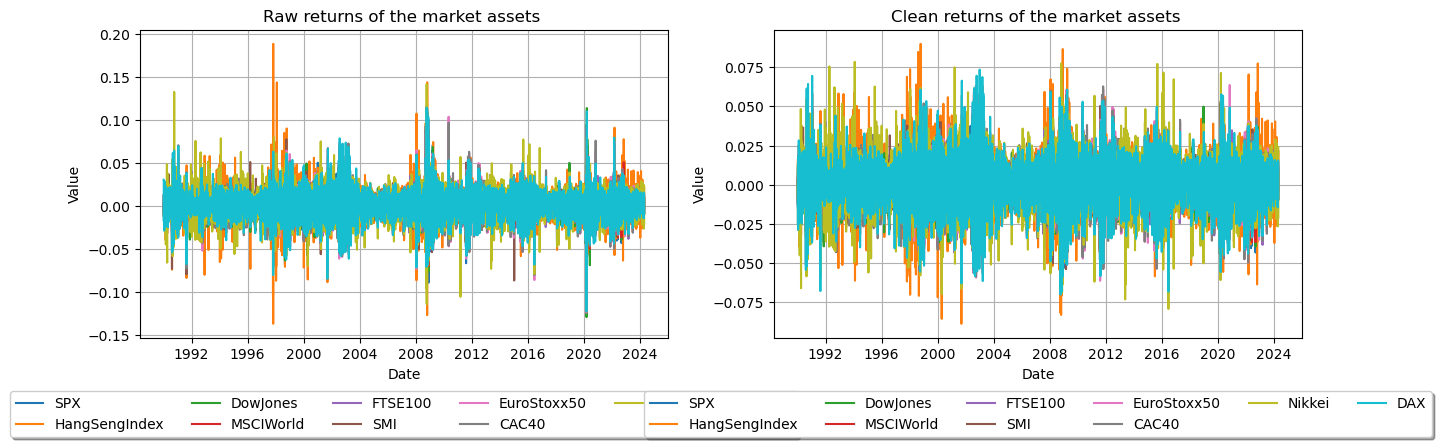

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

axs[0].plot(df_returns, label = df_returns.columns)
axs[0].set_title("Raw returns of the market assets ")
axs[0].set_ylabel("Value")
axs[0].set_xlabel("Date")
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6)
axs[0].grid()

axs[1].plot(clean_df_return, label = clean_df_return.columns)
axs[1].set_title("Clean returns of the market assets ")
axs[1].set_ylabel("Value")
axs[1].set_xlabel("Date")
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6)
axs[1].grid()

array([[<Axes: xlabel='Date'>, <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>],
       [<Axes: xlabel='Date'>, <Axes: xlabel='Date'>]], dtype=object)

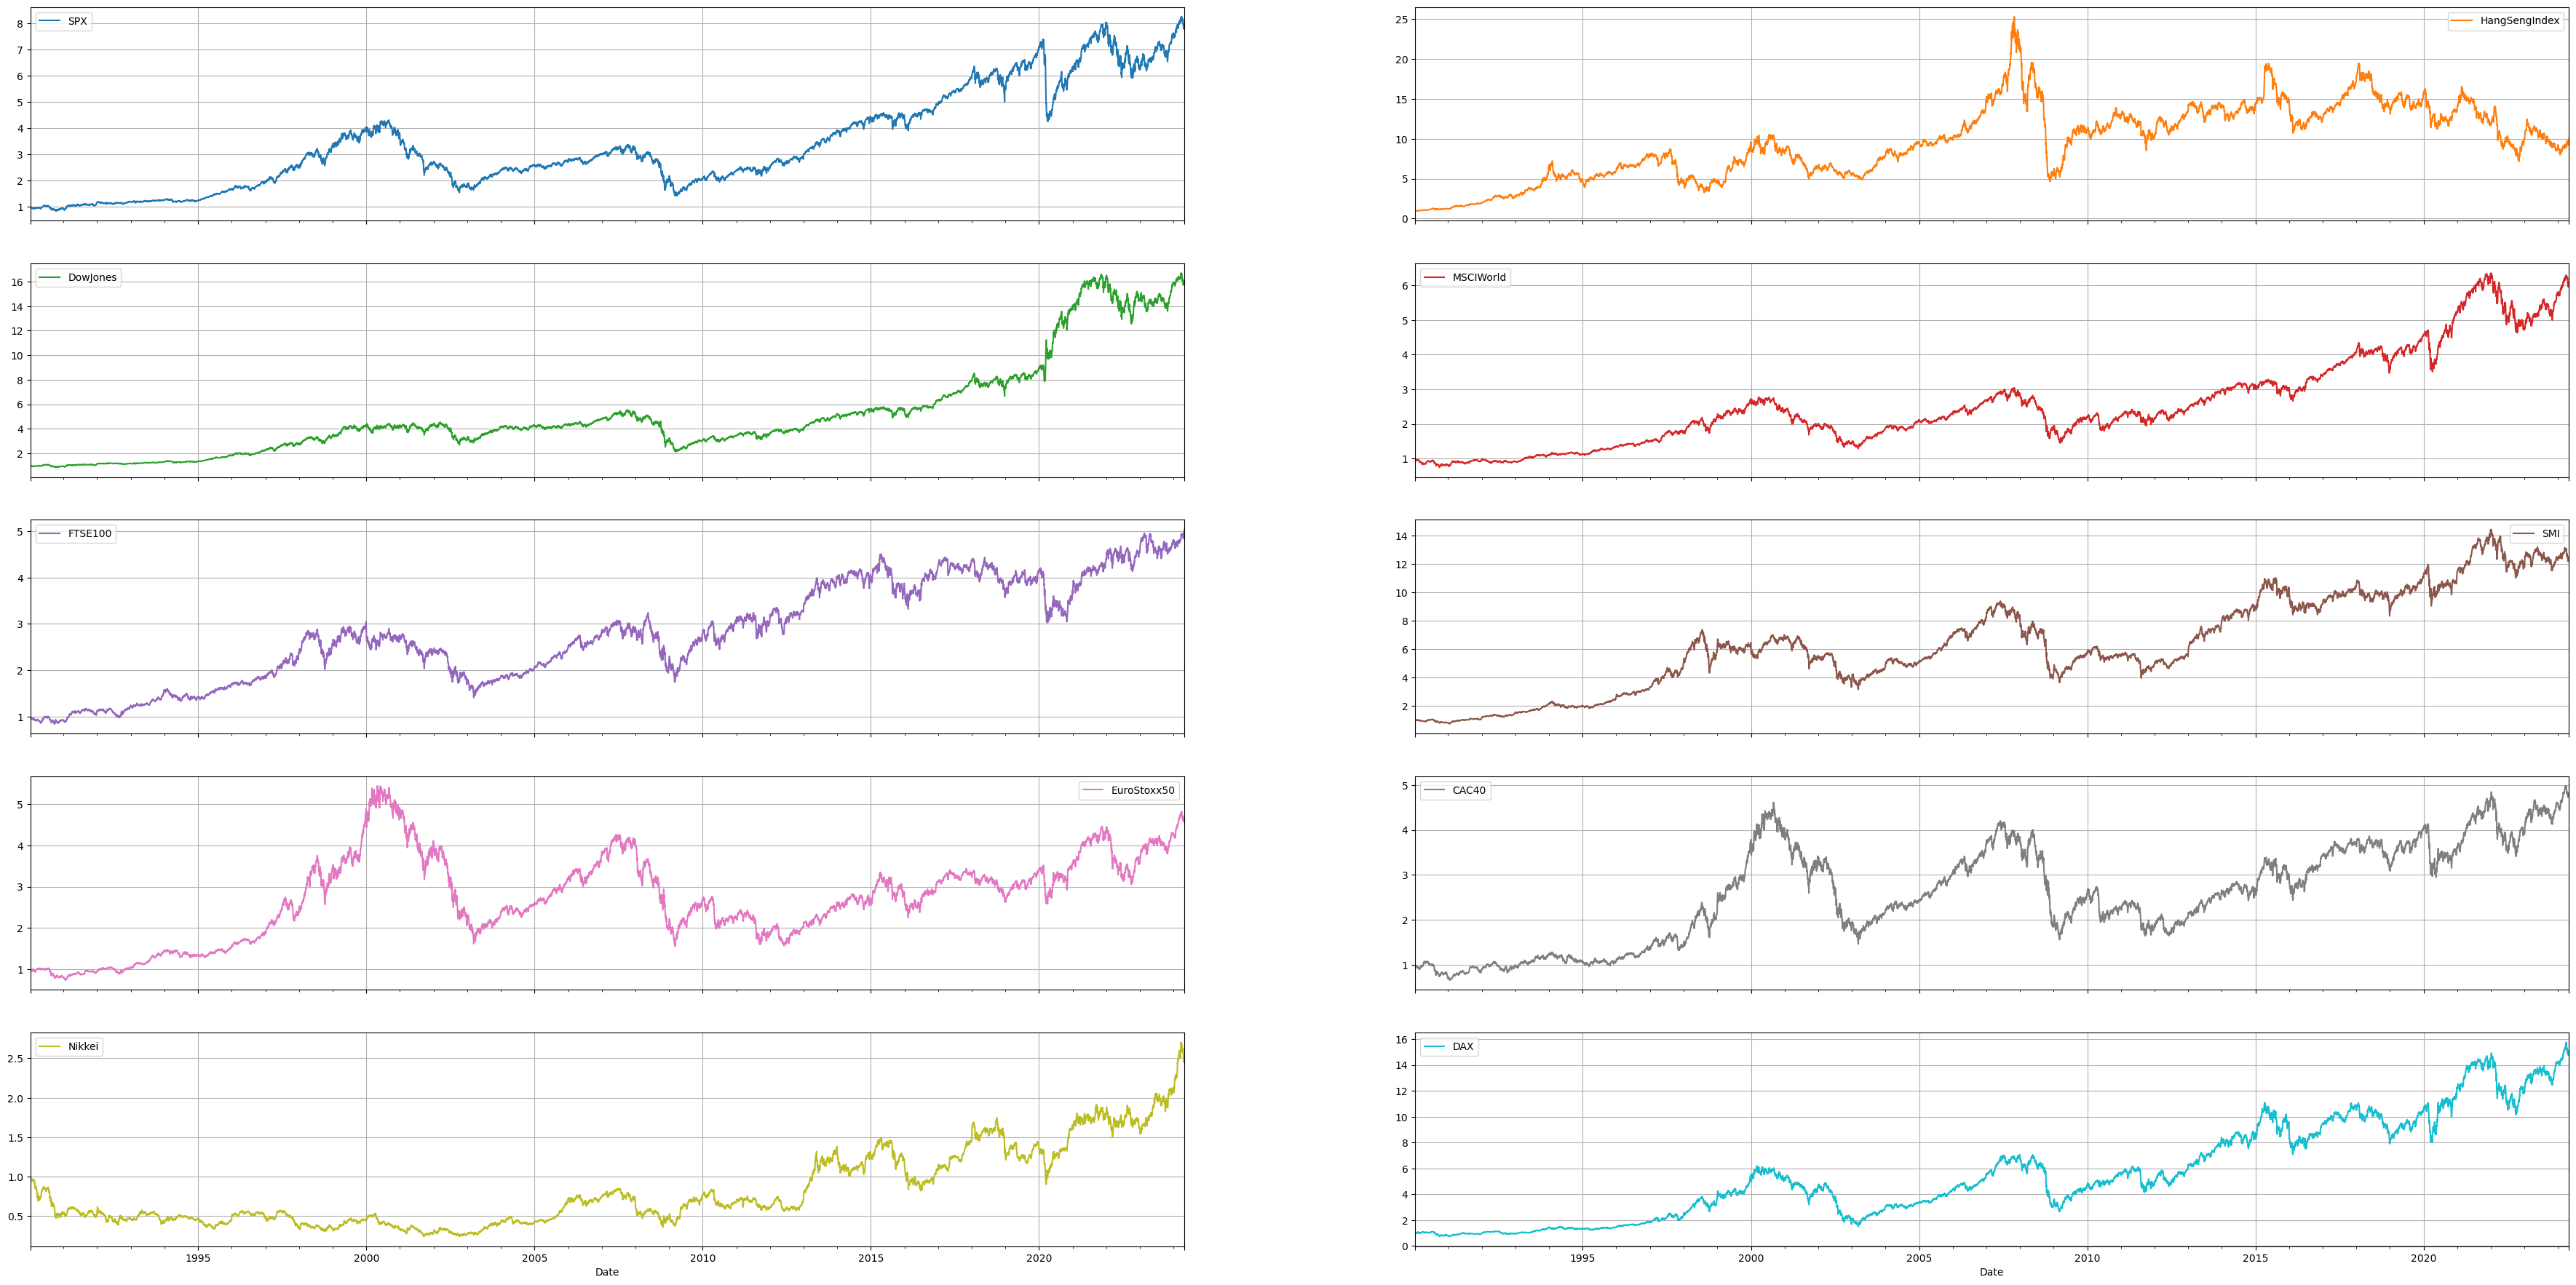

In [7]:
rebase_group_daily_data.plot(subplots = True, grid = True, layout = (10,2), figsize = (45,45))

In [8]:
def get_equally_weighted_volatility(df, windows) :
    return df.rolling(windows).std()

def get_target_volatility(df) :
    return df.expanding().std()

def fit_garch(p, q, df):
    """
    Fit GARCH(p, q) model to financial returns.

    Parameters:
    - p (int): Order of the autoregressive component.
    - q (int): Order of the moving average component.
    - returns (pd.Series): Time series of financial returns.

    Returns:
    - model_fit: Fitted GARCH(p, q) model.
    """
    # Define GARCH(p, q) model
    model = arch_model(df, vol='Garch', p=p, q=q)

    # Fit the model
    model_fit = model.fit()

    return model_fit

def get_garch_volatility(p, q, df) :
    model_fit = fit_garch(p, q, df)

    #Conditionnal Vol
    garch_volatility = model_fit.conditional_volatility
    #garch_volatility_data = garch_volatility.to_frame(name = "GARCH (" + str(p)+","+str(q)+")")
    
    return garch_volatility

def get_ewma_volatility(df, alpha):
    """
    Calculate Exponential Weighted Moving Average (EWMA) volatility for a given time series of returns.

    Parameters:
    - returns (pd.Series): Time series of returns.
    - alpha (float): Smoothing factor (0 < alpha <= 1).

    Returns:
    - ewma_volatility (pd.Series): Series containing EWMA volatility values.
    """
    squared_returns = df ** 2
    ewma_volatility = np.sqrt(squared_returns.ewm(alpha=alpha, adjust=False).mean())
    ewma_volatility.columns = ["EWMA "+str(1-alpha)]

    return ewma_volatility

def get_conditional_volatilities(df) :
    
    #GARCH(1,1)
    p = 1
    q = 1
    garch_volatility = get_garch_volatility(p, q, df)

    #EWMA 0.94
    alpha_94 = 0.06
    ewma_volatility_94 = get_ewma_volatility(df, alpha_94)
    #EWMA 0.97
    alpha_97 = 0.03
    ewma_volatility_97 = get_ewma_volatility(df, alpha_97)

    return garch_volatility, ewma_volatility_94, ewma_volatility_97

def get_ratio(df_target, df_forecast) : 
    daily_ratio = df_target/ df_forecast
    return daily_ratio

def get_weights(df_ratios):
    initial_weights = {'SPX': 0.1, 'HangSengIndex': 0.1, 'DowJones': 0.1, 'MSCIWorld': 0.1, 'FTSE100': 0.1, 'SMI': 0.1, 'EuroStoxx50': 0.1,'CAC40': 0.1, 'Nikkei': 0.1, 'DAX': 0.1}
    weights_history = pd.DataFrame(columns=initial_weights.keys())
    for index, row in df_ratios.iloc[1:].iterrows():
        weights = {key: initial_weights[key] * ratio for key, ratio in row.items()}
        total_weight = sum(weights.values())
        weights = {key: weight / total_weight for key, weight in weights.items()}
        weights_history.loc[index] = weights
    return weights_history

### Exemple de Vol targeting sur un seul index 

In [9]:
    df = clean_df_return["SPX"] * 100
    equally_weighted_volatility = get_equally_weighted_volatility(df, 30) 
    garch_volatility, ewma_volatility_94, ewma_volatility_97 = get_conditional_volatilities(df)
    target_volatility = get_target_volatility(df)
    
    #All Vols
    all_volatility = pd.concat([equally_weighted_volatility, garch_volatility, ewma_volatility_94, ewma_volatility_97, target_volatility], axis = 1)
    all_volatility.columns = ["Rolling Vol","Garch(1,1)","EWMA 0.94","EWMA 0.97", "Target"]

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1937096747707497.8
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4978951884.8669195
Iteration:      3,   Func. Count:     24,   Neg. LLF: 16394.784766227527
Iteration:      4,   Func. Count:     32,   Neg. LLF: 11912.825642850821
Iteration:      5,   Func. Count:     38,   Neg. LLF: 11812.753491145497
Iteration:      6,   Func. Count:     44,   Neg. LLF: 11926.850447501476
Iteration:      7,   Func. Count:     50,   Neg. LLF: 11781.094827036472
Iteration:      8,   Func. Count:     55,   Neg. LLF: 11781.094286449958
Iteration:      9,   Func. Count:     60,   Neg. LLF: 11781.094224821742
Iteration:     10,   Func. Count:     65,   Neg. LLF: 11781.094215431474
Iteration:     11,   Func. Count:     69,   Neg. LLF: 11781.094215430467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11781.094215431474
            Iterations: 11
            Function evaluations: 69
            Gradient eva

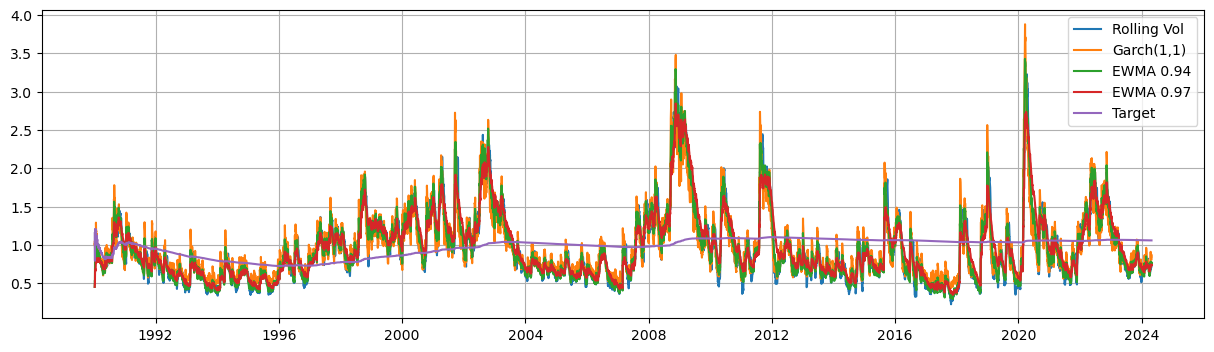

In [10]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(all_volatility, label = ["Rolling Vol","Garch(1,1)","EWMA 0.94","EWMA 0.97", "Target"])
ax.legend()
ax.grid()

#### Test for EW rolling vol rebalancing 1 month 

In [11]:
ratios = pd.DataFrame(clean_df_return)
target_volatility = []
weights_history = []
daily_pnl = []
cumulative_pnl = []
turnovers = []

for column in clean_df_return.columns:
    df = clean_df_return[column] * 100
    equally_weighted_volatility = get_equally_weighted_volatility(df, 32)
    target_volatility = get_target_volatility(df)
    ratios[column] = get_ratio(target_volatility,equally_weighted_volatility)
df_ratios = ratios.dropna()
weights_history = get_weights(df_ratios) 
turnover = get_turnover(weights_history)
turnovers.append(turnover)


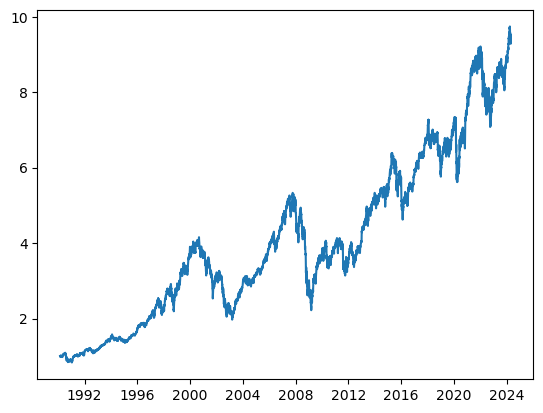

In [12]:
daily_pnl =clean_df_return  * weights_history.shift(1)
daily_pnl =daily_pnl.dropna()
cumulative_pnl = (daily_pnl.sum(axis=1) + 1).cumprod()
models_pnl = pd.DataFrame(cumulative_pnl, index=cumulative_pnl.index, columns=['ew_vol_rebalancing_1m'])
plt.plot(cumulative_pnl)

#### Test for EW rolling vol rebalancing 6 months

In [13]:
ratios = pd.DataFrame(clean_df_return)
target_volatility = []
weights_history = []
daily_pnl = []
cumulative_pnl = []

for column in clean_df_return.columns:
    df = clean_df_return[column] * 100
    equally_weighted_volatility = get_equally_weighted_volatility(df, 126)
    target_volatility = get_target_volatility(df)
    ratios[column] = get_ratio(target_volatility,equally_weighted_volatility)
df_ratios = ratios.dropna()
weights_history = get_weights(df_ratios) 
turnover = get_turnover(weights_history)
turnovers.append(turnover)


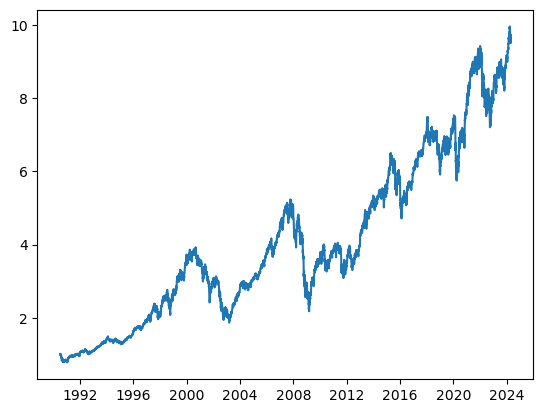

In [14]:
daily_pnl =clean_df_return  * weights_history.shift(1)
daily_pnl =daily_pnl.dropna()
cumulative_pnl = (daily_pnl.sum(axis=1) + 1).cumprod()
models_pnl['ew_vol_rebalancing_6m'] = cumulative_pnl
plt.plot(cumulative_pnl)

### Test for Garch 

In [15]:
ratios = pd.DataFrame(clean_df_return)
target_volatility = []
weights_history = []
daily_pnl = []
cumulative_pnl = []

for column in clean_df_return.columns: 
    df = clean_df_return[column] * 100
    garch_volatility, ewma_volatility_94, ewma_volatility_97 = get_conditional_volatilities(df)
    target_volatility = get_target_volatility(df)
    ratios[column] = get_ratio(target_volatility,garch_volatility)
df_ratios = ratios.dropna()
weights_history = get_weights(df_ratios) 
turnover = get_turnover(weights_history)
turnovers.append(turnover)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1937096747707497.8
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4978951884.8669195
Iteration:      3,   Func. Count:     24,   Neg. LLF: 16394.784766227527
Iteration:      4,   Func. Count:     32,   Neg. LLF: 11912.825642850821
Iteration:      5,   Func. Count:     38,   Neg. LLF: 11812.753491145497
Iteration:      6,   Func. Count:     44,   Neg. LLF: 11926.850447501476
Iteration:      7,   Func. Count:     50,   Neg. LLF: 11781.094827036472
Iteration:      8,   Func. Count:     55,   Neg. LLF: 11781.094286449958
Iteration:      9,   Func. Count:     60,   Neg. LLF: 11781.094224821742
Iteration:     10,   Func. Count:     65,   Neg. LLF: 11781.094215431474
Iteration:     11,   Func. Count:     69,   Neg. LLF: 11781.094215430467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11781.094215431474
            Iterations: 11
            Function evaluations: 69
            Gradient eva

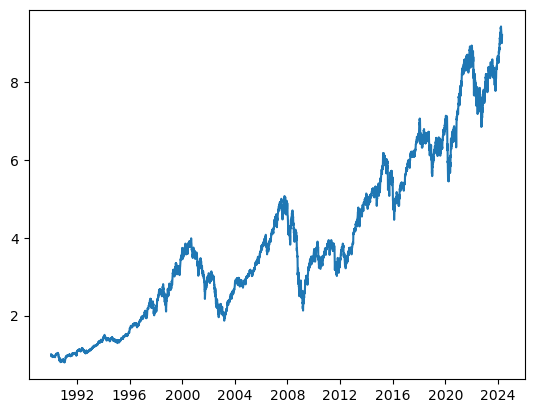

In [16]:
daily_pnl =clean_df_return  * weights_history.shift(1)
daily_pnl =daily_pnl.dropna()
cumulative_pnl = (daily_pnl.sum(axis=1) + 1).cumprod()
models_pnl["garch_rebalancing"] = cumulative_pnl
plt.plot(cumulative_pnl)

### EWMA 0.94 

In [17]:
ratios = pd.DataFrame(clean_df_return)
target_volatility = []
weights_history = []
daily_pnl = []
cumulative_pnl = []

for column in clean_df_return.columns:
    df = clean_df_return[column] * 100
    garch_volatility, ewma_volatility_94, ewma_volatility_97 = get_conditional_volatilities(df)
    target_volatility = get_target_volatility(df)
    ratios[column] = get_ratio(target_volatility,ewma_volatility_94)
df_ratios = ratios.dropna()
weights_history = get_weights(df_ratios) 
turnover = get_turnover(weights_history)
turnovers.append(turnover)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1937096747707497.8
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4978951884.8669195
Iteration:      3,   Func. Count:     24,   Neg. LLF: 16394.784766227527
Iteration:      4,   Func. Count:     32,   Neg. LLF: 11912.825642850821
Iteration:      5,   Func. Count:     38,   Neg. LLF: 11812.753491145497
Iteration:      6,   Func. Count:     44,   Neg. LLF: 11926.850447501476
Iteration:      7,   Func. Count:     50,   Neg. LLF: 11781.094827036472
Iteration:      8,   Func. Count:     55,   Neg. LLF: 11781.094286449958
Iteration:      9,   Func. Count:     60,   Neg. LLF: 11781.094224821742
Iteration:     10,   Func. Count:     65,   Neg. LLF: 11781.094215431474
Iteration:     11,   Func. Count:     69,   Neg. LLF: 11781.094215430467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11781.094215431474
            Iterations: 11
            Function evaluations: 69
            Gradient eva

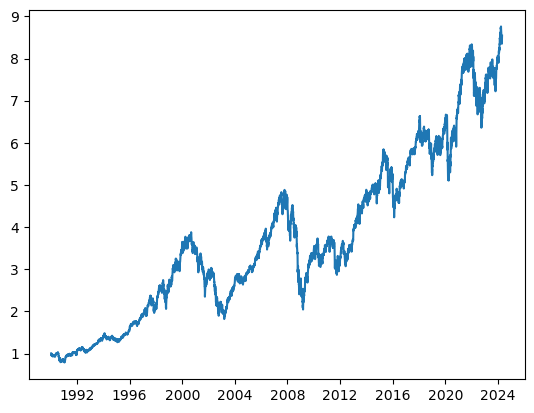

In [18]:
daily_pnl =clean_df_return  * weights_history.shift(1)
daily_pnl =daily_pnl.dropna()
cumulative_pnl = (daily_pnl.sum(axis=1) + 1).cumprod()
models_pnl["ewma94_rebalancing"] = cumulative_pnl
plt.plot(cumulative_pnl)

### EWMA 0.97

In [19]:
ratios = pd.DataFrame(clean_df_return)
target_volatility = []
weights_history = []
daily_pnl = []
cumulative_pnl = []

for column in clean_df_return.columns:
    df = clean_df_return[column] * 100
    garch_volatility, ewma_volatility_94, ewma_volatility_97 = get_conditional_volatilities(df)
    target_volatility = get_target_volatility(df)
    ratios[column] = get_ratio(target_volatility,ewma_volatility_97)
df_ratios = ratios.dropna()
weights_history = get_weights(df_ratios) 
turnover = get_turnover(weights_history)
turnovers.append(turnover)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1937096747707497.8
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4978951884.8669195
Iteration:      3,   Func. Count:     24,   Neg. LLF: 16394.784766227527
Iteration:      4,   Func. Count:     32,   Neg. LLF: 11912.825642850821
Iteration:      5,   Func. Count:     38,   Neg. LLF: 11812.753491145497
Iteration:      6,   Func. Count:     44,   Neg. LLF: 11926.850447501476
Iteration:      7,   Func. Count:     50,   Neg. LLF: 11781.094827036472
Iteration:      8,   Func. Count:     55,   Neg. LLF: 11781.094286449958
Iteration:      9,   Func. Count:     60,   Neg. LLF: 11781.094224821742
Iteration:     10,   Func. Count:     65,   Neg. LLF: 11781.094215431474
Iteration:     11,   Func. Count:     69,   Neg. LLF: 11781.094215430467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11781.094215431474
            Iterations: 11
            Function evaluations: 69
            Gradient eva

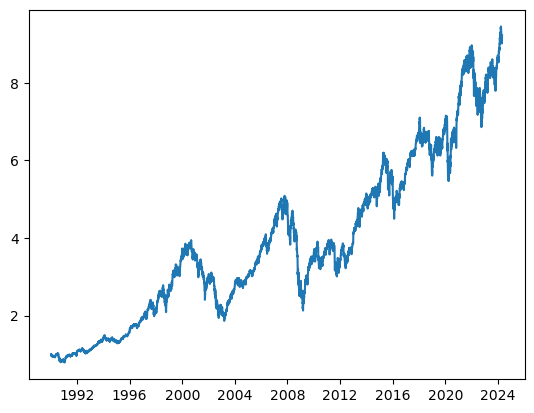

In [20]:
daily_pnl =clean_df_return  * weights_history.shift(1)
daily_pnl =daily_pnl.dropna()
cumulative_pnl = (daily_pnl.sum(axis=1) + 1).cumprod()
models_pnl["ewma97_rebalancing"] = cumulative_pnl
plt.plot(cumulative_pnl)

In [21]:
models_pnl

,ew_vol_rebalancing_1m,ew_vol_rebalancing_6m,garch_rebalancing,ewma94_rebalancing,ewma97_rebalancing
1990-02-22,1.005403,NaN,0.950896,0.948455,0.948441
1990-02-23,0.991161,NaN,0.938008,0.935252,0.935071
1990-02-26,0.985204,NaN,0.933622,0.930524,0.929401
1990-02-27,0.996817,NaN,0.944179,0.941149,0.940205
1990-02-28,1.002679,NaN,0.948898,0.946119,0.945325
...,...,...,...,...,...
2024-04-22,9.353152,9.572100,9.077348,8.413532,9.084009
2024-04-23,9.453219,9.673681,9.174873,8.503827,9.180794
2024-04-24,9.465861,9.684645,9.189686,8.517063,9.193458
2024-04-25,9.397617,9.613527,9.123176,8.455302,9.126649


In [22]:
ew_ret = (clean_df_return.mean(axis=1) + 1).cumprod()
#bc = (df_returns["SPX"] + 1).cumprod()

Metrics = get_risk_metrics(models_pnl)
Metrics["Turnover"] = turnovers
Metrics["Information Ratio"] = get_information_ratio(models_pnl,ew_ret)

Metrics

C:\Users\Paul\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,Volatility,Average Return,Skewness,Excess Kurtosis,Sharpe Ratio,Max Drawdown,Norm. Max Drawdown,VAR 99.0%,ES 99.0%,Turnover,Information Ratio
ew_vol_rebalancing_1m,0.136199,0.071522,0.553850,-3.550762,0.525129,-0.583327,-4.282908,0.024839,-0.000076,5.088293,-0.012482
ew_vol_rebalancing_6m,0.137117,0.074379,0.594467,-3.575426,0.542447,-0.583488,-4.255405,0.025158,-0.000082,1.247941,-0.015879
garch_rebalancing,0.136317,0.072027,0.571102,-3.547390,0.528376,-0.580111,-4.255596,0.024799,-0.000064,8.440127,-0.013404
ewma94_rebalancing,0.136124,0.070086,0.522253,-3.590067,0.514868,-0.580949,-4.26778,0.024669,-0.000065,5.603443,-0.012537
ewma97_rebalancing,0.136426,0.072360,0.568309,-3.564352,0.530397,-0.581538,-4.262651,0.024751,-0.000070,2.762358,-0.013992


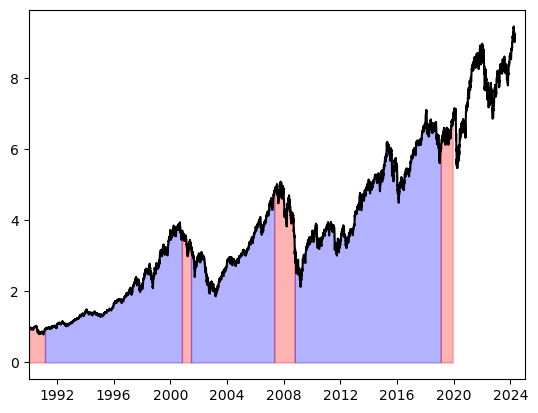

In [23]:
x = cumulative_pnl.index
y = cumulative_pnl


fig, ax = plt.subplots()
ax.plot(x, y, color='black')

ax.fill_between(x[:294], y[:294], color='red', alpha=0.3)
ax.fill_between(x[294:2814], y[294:2814], color='blue', alpha=0.3)
ax.fill_between(x[2814:2982], y[2814:2982], color='red', alpha=0.3)
ax.fill_between(x[2982:4515], y[2982:4515], color='blue', alpha=0.3)
ax.fill_between(x[4515:4893], y[4515:4893], color='red', alpha=0.3)
ax.fill_between(x[4893:7581], y[4893:7581], color='blue', alpha=0.3)
ax.fill_between(x[7581:7800], y[7581:7800], color='red', alpha=0.3)


ax.set_xlim(pd.Timestamp('1990-01-01'), pd.Timestamp('2024-12-31'))
plt.show()


### Accounting for Transaction Costs 

#### EW vol rebalancing 1 month

In [24]:
ratios = pd.DataFrame(clean_df_return)
target_volatility = []
weights_history = []
daily_pnl = []
cumulative_pnl_w_tc = []
turnovers = []

for column in clean_df_return.columns:
    df = clean_df_return[column] * 100
    equally_weighted_volatility = get_equally_weighted_volatility(df, 32)
    target_volatility = get_target_volatility(df)
    ratios[column] = get_ratio(target_volatility,equally_weighted_volatility)
df_ratios = ratios.dropna()
weights_history = get_weights(df_ratios) 
tc = get_transaction_costs(weights_history)


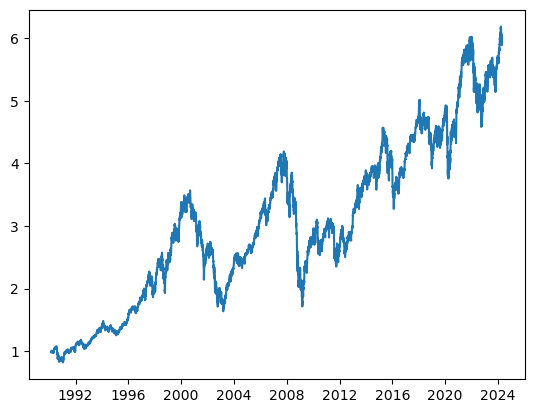

In [25]:
daily_pnl =clean_df_return  * weights_history.shift(1) - tc.shift(1)
daily_pnl =daily_pnl.dropna()
cumulative_pnl = (daily_pnl.sum(axis=1) + 1).cumprod()
models_pnl_w_tc = pd.DataFrame(cumulative_pnl, index=cumulative_pnl.index, columns=['ew_vol_rebalancing_1m_tc'])
plt.plot(cumulative_pnl)

### EW Vol rebalancing 6 months

In [26]:
ratios = pd.DataFrame(clean_df_return)
target_volatility = []
weights_history = []
daily_pnl = []
cumulative_pnl = []
turnovers = []

for column in clean_df_return.columns:
    df = clean_df_return[column] * 100
    equally_weighted_volatility = get_equally_weighted_volatility(df, 126)
    target_volatility = get_target_volatility(df)
    ratios[column] = get_ratio(target_volatility,equally_weighted_volatility)
df_ratios = ratios.dropna()
weights_history = get_weights(df_ratios) 
tc = get_transaction_costs(weights_history)


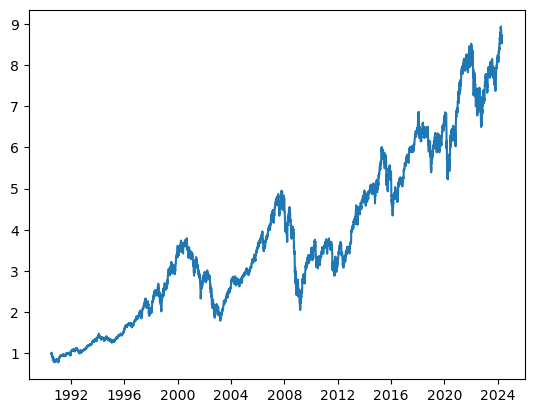

In [27]:
daily_pnl =clean_df_return  * weights_history.shift(1) - tc.shift(1)
daily_pnl =daily_pnl.dropna()
cumulative_pnl = (daily_pnl.sum(axis=1) + 1).cumprod()
models_pnl_w_tc['ew_vol_rebalancing_6m_tc'] = cumulative_pnl
plt.plot(cumulative_pnl)

### Garch

In [28]:
ratios = pd.DataFrame(clean_df_return)
target_volatility = []
weights_history = []
daily_pnl = []
cumulative_pnl = []

for column in clean_df_return.columns: 
    df = clean_df_return[column] * 100
    garch_volatility, ewma_volatility_94, ewma_volatility_97 = get_conditional_volatilities(df)
    target_volatility = get_target_volatility(df)
    ratios[column] = get_ratio(target_volatility,garch_volatility)
df_ratios = ratios.dropna()
weights_history = get_weights(df_ratios) 
tc = get_transaction_costs(weights_history)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1937096747707497.8
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4978951884.8669195
Iteration:      3,   Func. Count:     24,   Neg. LLF: 16394.784766227527
Iteration:      4,   Func. Count:     32,   Neg. LLF: 11912.825642850821
Iteration:      5,   Func. Count:     38,   Neg. LLF: 11812.753491145497
Iteration:      6,   Func. Count:     44,   Neg. LLF: 11926.850447501476
Iteration:      7,   Func. Count:     50,   Neg. LLF: 11781.094827036472
Iteration:      8,   Func. Count:     55,   Neg. LLF: 11781.094286449958
Iteration:      9,   Func. Count:     60,   Neg. LLF: 11781.094224821742
Iteration:     10,   Func. Count:     65,   Neg. LLF: 11781.094215431474
Iteration:     11,   Func. Count:     69,   Neg. LLF: 11781.094215430467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11781.094215431474
            Iterations: 11
            Function evaluations: 69
            Gradient eva

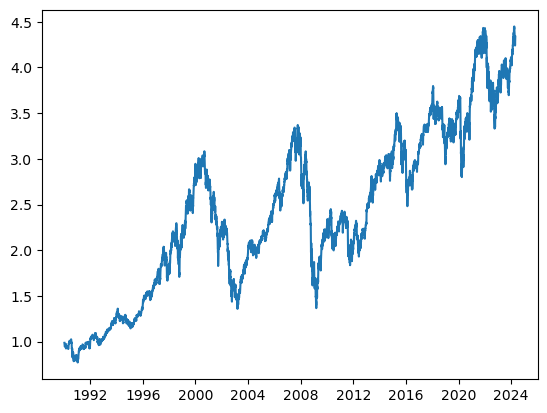

In [29]:
daily_pnl =clean_df_return  * weights_history.shift(1) - tc.shift(1)
daily_pnl =daily_pnl.dropna()
cumulative_pnl = (daily_pnl.sum(axis=1) + 1).cumprod()
models_pnl_w_tc["garch_rebalancing_tc"] = cumulative_pnl
plt.plot(cumulative_pnl)

### EWMA 0.94

In [30]:
ratios = pd.DataFrame(clean_df_return)
target_volatility = []
weights_history = []
daily_pnl = []
cumulative_pnl = []

for column in clean_df_return.columns:
    df = clean_df_return[column] * 100
    garch_volatility, ewma_volatility_94, ewma_volatility_97 = get_conditional_volatilities(df)
    target_volatility = get_target_volatility(df)
    ratios[column] = get_ratio(target_volatility,ewma_volatility_94)
df_ratios = ratios.dropna()
weights_history = get_weights(df_ratios) 
tc = get_transaction_costs(weights_history)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1937096747707497.8
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4978951884.8669195
Iteration:      3,   Func. Count:     24,   Neg. LLF: 16394.784766227527
Iteration:      4,   Func. Count:     32,   Neg. LLF: 11912.825642850821
Iteration:      5,   Func. Count:     38,   Neg. LLF: 11812.753491145497
Iteration:      6,   Func. Count:     44,   Neg. LLF: 11926.850447501476
Iteration:      7,   Func. Count:     50,   Neg. LLF: 11781.094827036472
Iteration:      8,   Func. Count:     55,   Neg. LLF: 11781.094286449958
Iteration:      9,   Func. Count:     60,   Neg. LLF: 11781.094224821742
Iteration:     10,   Func. Count:     65,   Neg. LLF: 11781.094215431474
Iteration:     11,   Func. Count:     69,   Neg. LLF: 11781.094215430467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11781.094215431474
            Iterations: 11
            Function evaluations: 69
            Gradient eva

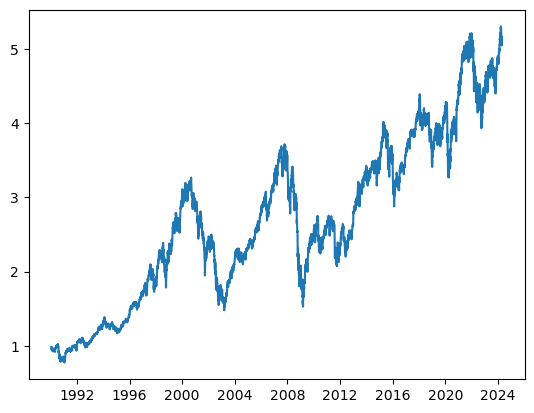

In [31]:
daily_pnl =clean_df_return  * weights_history.shift(1) - tc.shift(1)
daily_pnl =daily_pnl.dropna()
cumulative_pnl = (daily_pnl.sum(axis=1) + 1).cumprod()
models_pnl_w_tc["ewma94_rebalancing_tc"] = cumulative_pnl
plt.plot(cumulative_pnl)

### EWMA 0.97

In [32]:
ratios = pd.DataFrame(clean_df_return)
target_volatility = []
weights_history = []
daily_pnl = []
cumulative_pnl = []

for column in clean_df_return.columns:
    df = clean_df_return[column] * 100
    garch_volatility, ewma_volatility_94, ewma_volatility_97 = get_conditional_volatilities(df)
    target_volatility = get_target_volatility(df)
    ratios[column] = get_ratio(target_volatility,ewma_volatility_94)
df_ratios = ratios.dropna()
weights_history = get_weights(df_ratios) 
tc = get_transaction_costs(weights_history)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1937096747707497.8
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4978951884.8669195
Iteration:      3,   Func. Count:     24,   Neg. LLF: 16394.784766227527
Iteration:      4,   Func. Count:     32,   Neg. LLF: 11912.825642850821
Iteration:      5,   Func. Count:     38,   Neg. LLF: 11812.753491145497
Iteration:      6,   Func. Count:     44,   Neg. LLF: 11926.850447501476
Iteration:      7,   Func. Count:     50,   Neg. LLF: 11781.094827036472
Iteration:      8,   Func. Count:     55,   Neg. LLF: 11781.094286449958
Iteration:      9,   Func. Count:     60,   Neg. LLF: 11781.094224821742
Iteration:     10,   Func. Count:     65,   Neg. LLF: 11781.094215431474
Iteration:     11,   Func. Count:     69,   Neg. LLF: 11781.094215430467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11781.094215431474
            Iterations: 11
            Function evaluations: 69
            Gradient eva

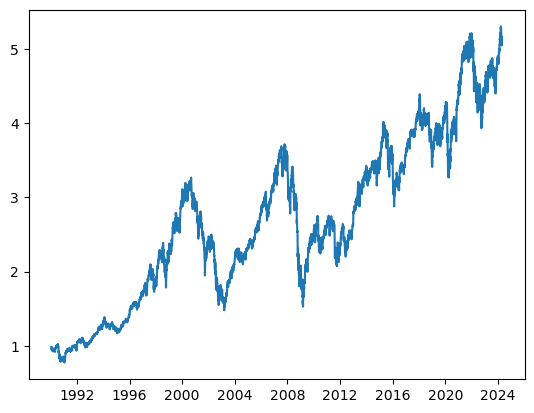

In [33]:
daily_pnl =clean_df_return  * weights_history.shift(1) - tc.shift(1)
daily_pnl =daily_pnl.dropna()
cumulative_pnl = (daily_pnl.sum(axis=1) + 1).cumprod()
models_pnl_w_tc["ewma97_rebalancing_tc"] = cumulative_pnl
plt.plot(cumulative_pnl)

In [34]:
ew_ret = (clean_df_return.mean(axis=1) + 1).cumprod()
#bc = (df_returns["SPX"] + 1).cumprod()

Metrics = get_risk_metrics(models_pnl_w_tc)
Metrics["Information Ratio"] = get_information_ratio(models_pnl_w_tc,ew_ret)

Metrics

C:\Users\Paul\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,Volatility,Average Return,Skewness,Excess Kurtosis,Sharpe Ratio,Max Drawdown,Norm. Max Drawdown,VAR 99.0%,ES 99.0%,Information Ratio
ew_vol_rebalancing_1m_tc,0.136215,0.058997,0.265534,-3.757900,0.433115,-0.590391,-4.334268,0.024869,-0.000026,-0.071305
ew_vol_rebalancing_6m_tc,0.137123,0.071476,0.535877,-3.629580,0.521258,-0.585264,-4.268175,0.025168,-0.000071,-0.090835
garch_rebalancing_tc,0.136307,0.051214,0.106645,-3.832423,0.375726,-0.594631,-4.362441,0.024932,-0.000007,-0.076225
ewma94_rebalancing_tc,0.136147,0.056269,0.208793,-3.791786,0.413297,-0.589182,-4.327558,0.024731,-0.000016,-0.071457
ewma97_rebalancing_tc,0.136147,0.056269,0.208793,-3.791786,0.413297,-0.589182,-4.327558,0.024731,-0.000016,-0.071457
